In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, unit_det


In [5]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, .4, 1
psi0 = 250.0 
Rc = 85.0 
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2


In [9]:
x[40], x[60]


(np.float64(-50.0), np.float64(50.0))

In [ ]:
for i in range(40, 60+5, 5):
    for j in range(40, 60+5, 5):
        


In [11]:
df_tests

,nic,njc,r
0,40,40,8
1,45,45,8
2,50,50,8
3,55,55,8
4,60,60,8


In [40]:
df_res = pd.DataFrame({'nic': np.nan, 'njc': np.nan, 'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

r = 8

spac = 2
nic, njc = np.arange(30, 70+spac, spac), np.arange(30, 70+spac, spac)
NIC, NJC = np.meshgrid(nic, njc)

df_tests = pd.DataFrame({'nic': NIC.flatten(),
                         'njc': NJC.flatten(),
})
df_tests['r'] = r

# dic_tests = {}
for t, test in enumerate(df_tests.index):
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))

    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    y2 = y[data.njc-data.r:data.njc+data.r+1]
    x2 = np.array([x[data.nic]] * len(y2))

    u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1]
    v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1]

    points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
    common_points = points1 & points2
    # Remove duplicates from (x1, y1, u1, v1)
    mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
    x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
    # Concatenate with unaltered second set
    xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
    ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, plot_flag=False)
    w_dop *= 1e-3

    df_res.loc[len(df_res)] = {'nic': int(data.nic), 'njc': int(data.njc), 'xc': xc_dop, 'yc': yc_dop, 'w': w_dop,
                               'q11': Q_dop[0,0], 'q12': Q_dop[0,1], 'q22': Q_dop[1,1],
                               'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}


df_res.index = ['Control'] + list(df_tests.index)
df_res['Error'] = (df_res - df_res.iloc[0]).abs()
df_res


,nic,njc,xc,yc,w,q11,q12,q22,Rc,psi0,A,Error
Control,NaN,NaN,0.000000,0.000000,-0.000151,1.091089,0.436436,1.091089,85.00000,2.500000e+02,-0.034602,0.000000e+00
0,30.0,30.0,-1073.972041,-1073.972041,0.000154,0.024099,1.000290,0.024099,2011.65246,-6.460860e+06,1.596557,6.465189e+06
1,32.0,30.0,-41.249196,636.814804,-0.000137,0.014100,-1.000289,0.041058,NaN,NaN,NaN,6.816278e+02
2,34.0,30.0,-30.864082,169.949871,-0.000092,0.064684,-1.004554,0.141138,NaN,NaN,NaN,2.042314e+02
3,36.0,30.0,-18.796600,62.610801,-0.000091,0.147206,-1.022028,0.302577,NaN,NaN,NaN,8.459832e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
436,62.0,70.0,3.270053,-13.704954,-0.000099,0.288530,-1.083454,0.602617,NaN,NaN,NaN,1.978598e+01
437,64.0,70.0,18.796600,-62.610801,-0.000091,0.147206,-1.022028,0.302577,NaN,NaN,NaN,8.459832e+01
438,66.0,70.0,30.864082,-169.949871,-0.000092,0.064684,-1.004554,0.141138,NaN,NaN,NaN,2.042314e+02
439,68.0,70.0,41.249196,-636.814804,-0.000137,0.014100,-1.000289,0.041058,NaN,NaN,NaN,6.816278e+02


Text(0, 0.5, 'y (km)')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


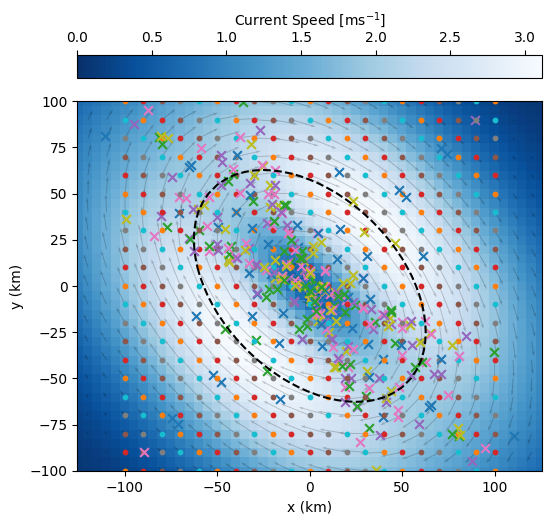

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))

cmap = 'Blues_r'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax, orientation='horizontal', location='top', label='Current Speed [ms$^{-1}$]')
ax.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

ax.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

for k in range(1, len(df_res)):
    data = df_res.iloc[k]
    ax.scatter(data.xc, data.yc, marker='x', s=40)
    ax.scatter(x[int(data.nic)], y[int(data.njc)], marker='.', s=40)

ax.axis('equal')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')


np.float64(40.0)